![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 020</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">過去コンペの予測ラベル</li>
    <li style = "color:#4c1c84;
                font-size:14px">TFIDF</li>
    <li style = "color:#4c1c84;
                font-size:14px">SVR</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")

In [10]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf

In [11]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 128,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "020_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 64,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 32,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "studio-ousia/luke-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MarginRankingLoss",
}

config = Box(config)
pprint(config)

{'backbone': <Box: {'name': 'studio-ousia/luke-base', 'output_dim': 1}>,
 'entity': 'dataskywalker',
 'environment': 'AWS',
 'epoch': 5,
 'exp_name': '020_exp',
 'loss': 'nn.MarginRankingLoss',
 'margin': 0.5,
 'max_length': 128,
 'n_fold': 5,
 'optimizer': <Box: {'name': 'torch.optim.AdamW', 'params': {'lr': 1e-06}}>,
 'project': 'Jigsaw',
 'root': '/content/drive/MyDrive/kaggle/Jigsaw/raw',
 'scheduler': {'name': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': <Box: {'T_0': 20, 'eta_min': 0}>},
 'seed': 42,
 'test_loader': {'batch_size': 32,
                 'drop_last': False,
                 'num_workers': 1,
                 'pin_memory': True,
                 'shuffle': False},
 'train_fold': <BoxList: [0, 1, 2, 3, 4]>,
 'train_loader': {'batch_size': 32,
                  'drop_last': True,
                  'num_workers': 1,
                  'pin_memory': True,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 8,
   

In [12]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/020_exp
OUTPUT_DIR is ../data/interim/020_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [13]:
# Seed固定
seed_everything(config.seed)

42

In [14]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [15]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [16]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Jigsaw 1st
</h1>
<br>

In [17]:
train_df = pd.read_csv("../data/external/jigsaw-classification/train.csv.zip")
print(train_df.shape)
display(train_df.head())

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [18]:
def sample_df(df:pd.DataFrame, frac=0.2):
    
    '''
    train_dfからtoxicとnon_toxicを抽出
    non_toxicの割合をfracで調整
    '''
    
    label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    df["y"] = df[label_cols].sum(axis=1)
    df["y"] = df["y"]/df["y"].max()

    toxic_df = df[df["y"]>0].reset_index(drop=True)
    nontoxic_df = df[df["y"]==0].reset_index(drop=True)
    nontoxic_df = nontoxic_df.sample(frac=frac, random_state=config.seed)
    
    df = pd.concat([toxic_df, nontoxic_df], axis=0).sample(frac=1).reset_index(drop=True)
    
    return df

In [19]:
with timer("sampling df"):
    
    train_df = sample_df(train_df, frac=0.1)
    display(train_df.head())

<< sampling df >> Start


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,y
0,ab52a5eae0a34feb,You should be BOLD. CookieMonster755,0,0,0,0,0,0,0.000000
1,a45f2ab74cc1213d,"The nameless correspondent \n\nn June 2010, a ...",0,0,0,0,0,0,0.000000
2,60efc53b2350dd56,So when is coming going to warn YOU about your...,1,0,1,0,0,0,0.333333
3,377ff5f8b6c03f17,Malta is an Arab \n\nWhy are people lying? It ...,1,0,1,0,1,0,0.500000
4,861232fa06fd2382,Thank you for experimenting with Wikipedia. Y...,0,0,0,0,0,0,0.000000


<< sampling df >> 1.8GB(-0.0GB):0.1sec


<br>
<h2 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Text Cleaning
</h2>
<br>

In [20]:
def clean(data, col):

    data[col] = data[col].str.lower()
    # Clean some punctutation
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()
    
    # removing characters
    data[col] = data[col].str.replace(r"[^a-zA-Z0-9]",' ')    
    
    return data

In [21]:
with timer("sampling df"):
    
    train_df = clean(train_df, "comment_text")
    val_df = clean(val_df, "more_toxic")
    val_df = clean(val_df, "less_toxic")
    test_df = clean(test_df, "text")
    display(train_df.head())
    display(val_df.head())
    display(test_df.head())

<< sampling df >> Start


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,y
0,ab52a5eae0a34feb,you should be bold cookiemonster755,0,0,0,0,0,0,0.000000
1,a45f2ab74cc1213d,the nameless correspondent n june 2010 a ...,0,0,0,0,0,0,0.000000
2,60efc53b2350dd56,so when is coming going to warn you about your...,1,0,1,0,0,0,0.333333
3,377ff5f8b6c03f17,malta is an arab why are people lying it...,1,0,1,0,1,0,0.500000
4,861232fa06fd2382,thank you for experimenting with wikipedia yo...,0,0,0,0,0,0,0.000000


,worker,less_toxic,more_toxic
0,313,this article sucks woo woo woo,what wher is...
1,188,and yes people should recognize that but the...,daphne guinness top of the mornin my fav...
2,82,western media yup because every crime i...,atom you don t believe actual photos of mas...
3,347,and you removed it you numbskull i don t...,you seem to have sand in your vagina migh...
4,539,smelly vagina bluerasberry why don t you...,hey way to support nazis you racist


,comment_id,text
0,114890,gjalexei you asked about whether ther...
1,732895,looks like be have an abuser can you please ...
2,1139051,i confess to having complete and apparently b...
3,1434512,freud s ideas are certainly much discu...
4,2084821,it is not just you this is a laundry list of ...


<< sampling df >> 1.8GB(-0.0GB):17.2sec


<br>
<h2 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    TFIDF + Ridge
</h2>
<br>

In [22]:
## tfidf
vec = TfidfVectorizer(
    analyzer="char_wb",
    max_df=0.7, 
    min_df=1, 
    ngram_range=(2, 6)
)
X = vec.fit_transform(train_df["comment_text"])
print(X.shape)

(30560, 364773)


In [23]:
ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X, train_df["y"].values)

Ridge(alpha=0.5)

In [24]:
less_vec = vec.transform(val_df["less_toxic"])
more_vec = vec.transform(val_df["more_toxic"])

less_pred = ridge_model.predict(less_vec)
more_pred = ridge_model.predict(more_vec)

test_vec = vec.transform(test_df["text"])
test_pred = ridge_model.predict(test_vec)

In [26]:
OOF_DF = pd.DataFrame()
OOF_DF["Ridge_less_pred"] = less_pred
OOF_DF["Ridge_more_pred"] = more_pred
OOF_DF["Ridge_diff"] = OOF_DF["Ridge_more_pred"] - OOF_DF["Ridge_less_pred"]

ridge_score = OOF_DF[OOF_DF["Ridge_diff"]>0]["Ridge_diff"].count()/len(OOF_DF)
print(f"TFIDF + Ridge Model Score: {ridge_score:.6f}")

TFIDF + Ridge Model Score: 0.680949


In [27]:
test_df["jigsaw1st_tfidf_ridge"] = test_pred

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Ruddit + TFIDF + Ridge
</h21>
<br>

In [28]:
ruddit_df = pd.read_csv("../data/external/Ruddit/Dataset/ruddit_with_text.csv")
print(ruddit_df.shape)
display(ruddit_df.head())

(5838, 5)


,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022
2,42g75o,cza23qx,[deleted],https://www.reddit.com/r/changemyview/comments...,0.167
3,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146
4,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083


In [29]:
ruddit_df = ruddit_df[ruddit_df["txt"]!="[deleted]"].reset_index(drop=True)
ruddit_df = clean(ruddit_df, "txt")
display(ruddit_df.head())

,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,the difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083
1,42g75o,cza1wdh,the myth is that the gap is entirely based o...,https://www.reddit.com/r/changemyview/comments...,-0.022
2,42g75o,cza2bw8,the assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146
3,42g75o,cza2iji,you said in the op that s not what they re...,https://www.reddit.com/r/changemyview/comments...,-0.083
4,42g75o,cza2jj3,men and women are not payed less for the same...,https://www.reddit.com/r/changemyview/comments...,-0.042


In [30]:
## tfidf
rud_vec = TfidfVectorizer(
    analyzer="char_wb",
    max_df=0.7, 
    min_df=3, 
    ngram_range=(3, 4)
)
X = rud_vec.fit_transform(ruddit_df["txt"])

In [31]:
rud_ridge_model = Ridge(alpha=0.5)
rud_ridge_model.fit(X, ruddit_df["offensiveness_score"].values)

Ridge(alpha=0.5)

In [32]:
less_vec = rud_vec.transform(val_df["less_toxic"])
more_vec = rud_vec.transform(val_df["more_toxic"])

less_pred = rud_ridge_model.predict(less_vec)
more_pred = rud_ridge_model.predict(more_vec)

test_vec = rud_vec.transform(test_df["text"])
test_pred = rud_ridge_model.predict(test_vec)

In [33]:
OOF_DF["Ruddit_Ridge_less_pred"] = less_pred
OOF_DF["Ruddit_Ridge_more_pred"] = more_pred
OOF_DF["Ruddit_Ridge_diff"] = OOF_DF["Ruddit_Ridge_more_pred"] - OOF_DF["Ruddit_Ridge_less_pred"]

ridge_score = OOF_DF[OOF_DF["Ruddit_Ridge_diff"]>0]["Ruddit_Ridge_diff"].count()/len(OOF_DF)
print(f"Ruddit + TFIDF + Ridge Model Score: {ridge_score:.6f}")

Ruddit + TFIDF + Ridge Model Score: 0.634781


In [34]:
test_df["ruddit_tfidf_ridge"] = test_pred

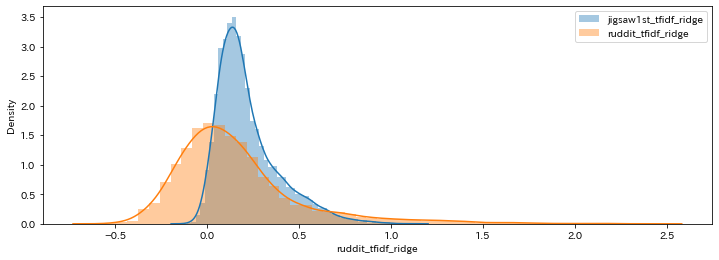

In [35]:
plt.figure(figsize=(12, 4))
sns.distplot(test_df["jigsaw1st_tfidf_ridge"], label="jigsaw1st_tfidf_ridge")
sns.distplot(test_df["ruddit_tfidf_ridge"], label="ruddit_tfidf_ridge")
plt.legend()
plt.show()

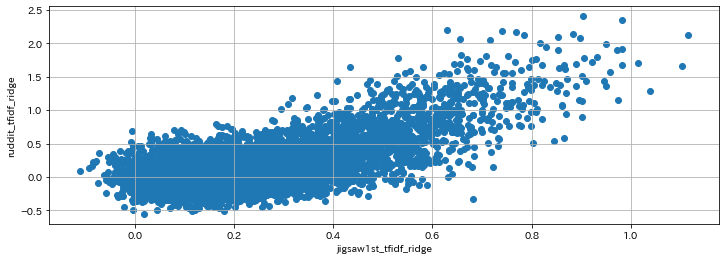

In [36]:
plt.figure(figsize=(12, 4))
plt.scatter(test_df["jigsaw1st_tfidf_ridge"], test_df["ruddit_tfidf_ridge"])
plt.xlabel("jigsaw1st_tfidf_ridge")
plt.ylabel("ruddit_tfidf_ridge")
plt.grid()
plt.show()

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Detoxify
</h1>
<br>

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Original
</h2>
<br>

In [37]:
loaded = torch.load("../data/external/detoxify_ckpt/toxic_original-c1212f89.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 6,
 'model_type': 'bert-base-uncased',
 'model_name': 'BertForSequenceClassification',
 'tokenizer_name': 'BertTokenizer'}

In [39]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

bert_tokeninzer = BertTokenizer.from_pretrained('roberta-base')
bert_tokeninzer.save_pretrained(OUTPUT_DIR/f"roberta-base")
bert_model = BertForSequenceClassification.from_pretrained('roberta-base')
bert_model.save_pretrained(OUTPUT_DIR/'roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
sys.path.append("../src/utils/detoxify")

from detoxify import Detoxify

detox_model = Detoxify(
    'original', 
    checkpoint="../data/external/detoxify_ckpt/toxic_original-c1212f89.ckpt",
    device="cuda"
)
detox_model.predict(train_df["comment_text"].tolist()[0])

In [ ]:
val_df['more_detoxify_score'] = val_df['more_toxic'].progress_map(lambda line: detox_model.predict(line))
val_df['less_detoxify_score'] = val_df['less_toxic'].progress_map(lambda line: detox_model.predict(line))

more_detoxify_df = val_df["more_detoxify_score"].apply(pd.Series)
less_detoxify_df = val_df["less_detoxify_score"].apply(pd.Series)

In [ ]:
OOF_DF["more_detoxify_unbiased_score"] = more_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["less_detoxify_unbiased_score"] = less_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["detoxify_diff"] = OOF_DF["more_detoxify_score"] - OOF_DF["less_detoxify_score"]
detoxify_score = OOF_DF[OOF_DF["detoxify_diff"]>0]["detoxify_diff"].count()/len(OOF_DF)
print(f"Detoxify Model Score: {detoxify_score:.6f}")

In [45]:
OOF_DF.head()

,Ridge_less_pred,Ridge_more_pred,Ridge_diff,Ruddit_Ridge_less_pred,Ruddit_Ridge_more_pred,Ruddit_Ridge_diff,more_detoxify_score,less_detoxify_score,detoxify_diff
0,0.328368,0.213607,-0.114761,-0.162604,-0.083511,0.079093,0.953505,2.143710,-1.190205
1,0.045194,0.171636,0.126443,-0.098692,-0.040686,0.058006,1.964873,0.002753,1.962120
2,0.142531,0.111072,-0.031459,0.154540,0.036213,-0.118327,0.574108,0.051482,0.522626
3,0.285728,0.539906,0.254178,0.077980,0.315090,0.237110,3.406781,1.015747,2.391034
4,0.298790,0.301840,0.003050,0.063660,0.342435,0.278775,1.921882,2.486528,-0.564646


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Unbiased
</h2>
<br>

In [38]:
loaded = torch.load("../data/external/detoxify_ckpt/toxic_debiased-c7548aa0.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 16,
 'model_type': 'roberta-base',
 'model_name': 'RobertaForSequenceClassification',
 'tokenizer_name': 'RobertaTokenizer'}

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

bert_tokeninzer = RobertaTokenizer.from_pretrained('roberta-base')
bert_tokeninzer.save_pretrained(OUTPUT_DIR/f"roberta-base")
bert_model = RobertaForSequenceClassification.from_pretrained('roberta-base')
bert_model.save_pretrained(OUTPUT_DIR/'roberta-base')

In [ ]:
detox_model = Detoxify(
    'unbiased', 
    checkpoint="../data/external/detoxify_ckpt/toxic_debiased-c7548aa0.ckpt",
    device="cuda"
)
detox_model.predict(train_df["comment_text"].tolist()[0])

In [ ]:
val_df['more_detoxify_unbiased_score'] = val_df['more_toxic'].progress_map(lambda line: detox_model.predict(line))
val_df['less_detoxify_unbiased_score'] = val_df['less_toxic'].progress_map(lambda line: detox_model.predict(line))

more_detoxify_df = val_df["more_detoxify_unbiased_score"].apply(pd.Series)
less_detoxify_df = val_df["less_detoxify_unbiased_score"].apply(pd.Series)

In [ ]:
detoxify_cols = more_detoxify_df.columns.tolist()


OOF_DF["more_detoxify_unbiased_score"] = more_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["less_detoxify_unbiased_score"] = less_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["detoxify_unbiased_diff"] = OOF_DF["more_detoxify_unbiased_score"] - OOF_DF["less_detoxify_unbiased_score"]
detoxify_score = OOF_DF[OOF_DF["detoxify_unbiased_diff"]>0]["detoxify_unbiased_diff"].count()/len(OOF_DF)
print(f"Detoxify Unbiased Model Score: {detoxify_score:.6f}")

In [79]:

# OOF_DF["more_detoxify_unbiased_score"] = more_detoxify_df[detoxify_cols].sum(axis=1)
# OOF_DF["less_detoxify_unbiased_score"] = less_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["detoxify_unbiased_diff"] = OOF_DF["more_detoxify_unbiased_score"] - OOF_DF["less_detoxify_unbiased_score"]
detoxify_score = OOF_DF[OOF_DF["detoxify_unbiased_diff"]>0]["detoxify_unbiased_diff"].count()/len(OOF_DF)
print(f"Detoxify Unbiased Model Score: {detoxify_score:.6f}")

Detoxify Unbiased Model Score: 0.694832


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Multilingual
</h2>
<br>

In [56]:
loaded = torch.load("../data/external/detoxify_ckpt/multilingual_debiased-0b549669.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 16,
 'model_type': 'xlm-roberta-base',
 'model_name': 'XLMRobertaForSequenceClassification',
 'tokenizer_name': 'XLMRobertaTokenizer'}

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

bert_tokeninzer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
bert_tokeninzer.save_pretrained(OUTPUT_DIR/f"xlm-roberta-base")
bert_model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')
bert_model.save_pretrained(OUTPUT_DIR/'xlm-roberta-base')

In [58]:
detox_model = Detoxify(
    'multilingual', 
    checkpoint="../data/external/detoxify_ckpt/multilingual_debiased-0b549669.ckpt",
    device="cuda"
)
detox_model.predict(train_df["comment_text"].tolist()[0])

{'toxicity': 0.17353217,
 'severe_toxicity': 0.0002474817,
 'obscene': 0.007298799,
 'identity_attack': 0.0027313058,
 'insult': 0.07068583,
 'threat': 0.00070219924,
 'sexual_explicit': 0.00090324157}

In [59]:
val_df['more_detoxify_multi_score'] = val_df['more_toxic'].progress_map(lambda line: detox_model.predict(line))
val_df['less_detoxify_multi_score'] = val_df['less_toxic'].progress_map(lambda line: detox_model.predict(line))

more_detoxify_df = val_df["more_detoxify_multi_score"].apply(pd.Series)
less_detoxify_df = val_df["less_detoxify_multi_score"].apply(pd.Series)

  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

In [61]:
detoxify_cols = more_detoxify_df.columns.tolist()

OOF_DF["more_detoxify_multi_score"] = more_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["less_detoxify_multi_score"] = less_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["detoxify_multi_diff"] = OOF_DF["more_detoxify_multi_score"] - OOF_DF["less_detoxify_multi_score"]
detoxify_score = OOF_DF[OOF_DF["detoxify_multi_diff"]>0]["detoxify_multi_diff"].count()/len(OOF_DF)
print(f"Detoxify Multilingual Model Score: {detoxify_score:.6f}")

Detoxify Multilingual Model Score: 0.691976


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Original-Small
</h2>
<br>

In [63]:
loaded = torch.load("../data/external/detoxify_ckpt/original-albert-0e1d6498.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 6,
 'model_type': 'albert-base-v2',
 'model_name': 'AlbertForSequenceClassification',
 'tokenizer_name': 'AlbertTokenizer'}

In [64]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification

bert_tokeninzer = AlbertTokenizer.from_pretrained('albert-base-v2')
bert_tokeninzer.save_pretrained(OUTPUT_DIR/f"albert-base-v2")
bert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2')
bert_model.save_pretrained(OUTPUT_DIR/'albert-base-v2')

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [65]:
detox_model = Detoxify(
    'original-small', 
    checkpoint="../data/external/detoxify_ckpt/original-albert-0e1d6498.ckpt",
    device="cuda"
)
detox_model.predict(train_df["comment_text"].tolist()[0])

{'toxicity': 0.008386395,
 'severe_toxicity': 6.696652e-05,
 'obscene': 0.0007168955,
 'threat': 9.130974e-05,
 'insult': 0.00030911065,
 'identity_attack': 0.00019027268}

In [66]:
val_df['more_detoxify_ori_small_score'] = val_df['more_toxic'].progress_map(lambda line: detox_model.predict(line))
val_df['less_detoxify_ori_small_score'] = val_df['less_toxic'].progress_map(lambda line: detox_model.predict(line))

more_detoxify_df = val_df["more_detoxify_ori_small_score"].apply(pd.Series)
less_detoxify_df = val_df["less_detoxify_ori_small_score"].apply(pd.Series)


  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

In [68]:
detoxify_cols = more_detoxify_df.columns.tolist()

OOF_DF["more_detoxify_ori_small_score"] = more_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["less_detoxify_ori_small_score"] = less_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["detoxify_ori_small_diff"] = OOF_DF["more_detoxify_ori_small_score"] - OOF_DF["less_detoxify_ori_small_score"]
detoxify_score = OOF_DF[OOF_DF["detoxify_ori_small_diff"]>0]["detoxify_ori_small_diff"].count()/len(OOF_DF)
print(f"Detoxify Original Small Model Score: {detoxify_score:.6f}")

Detoxify Original Small Model Score: 0.696127


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Unbiased-Small
</h2>
<br>

In [70]:
loaded = torch.load("../data/external/detoxify_ckpt/unbiased-albert-c8519128.ckpt")
loaded["config"]["arch"]["args"]

{'num_classes': 16,
 'model_type': 'albert-base-v2',
 'model_name': 'AlbertForSequenceClassification',
 'tokenizer_name': 'AlbertTokenizer'}

In [71]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification

bert_tokeninzer = AlbertTokenizer.from_pretrained('albert-base-v2')
bert_tokeninzer.save_pretrained(OUTPUT_DIR/f"albert-base-v2")
bert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2')
bert_model.save_pretrained(OUTPUT_DIR/'albert-base-v2')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [72]:
detox_model = Detoxify(
    'unbiased-small', 
    checkpoint="../data/external/detoxify_ckpt/unbiased-albert-c8519128.ckpt",
    device="cuda"
)
detox_model.predict(train_df["comment_text"].tolist()[0])

{'toxicity': 0.0058559845,
 'severe_toxicity': 2.6555358e-06,
 'obscene': 0.00012663109,
 'identity_attack': 0.0001412511,
 'insult': 0.0049695116,
 'threat': 0.00011448261,
 'sexual_explicit': 0.00010405782}

In [73]:
val_df['more_detoxify_unb_small_score'] = val_df['more_toxic'].progress_map(lambda line: detox_model.predict(line))
val_df['less_detoxify_unb_small_score'] = val_df['less_toxic'].progress_map(lambda line: detox_model.predict(line))

more_detoxify_df = val_df["more_detoxify_unb_small_score"].apply(pd.Series)
less_detoxify_df = val_df["less_detoxify_unb_small_score"].apply(pd.Series)


  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

In [74]:
detoxify_cols = more_detoxify_df.columns.tolist()

OOF_DF["more_detoxify_unb_small_score"] = more_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["less_detoxify_unb_small_score"] = less_detoxify_df[detoxify_cols].sum(axis=1)
OOF_DF["detoxify_unb_small_diff"] = OOF_DF["more_detoxify_unb_small_score"] - OOF_DF["less_detoxify_unb_small_score"]
detoxify_score = OOF_DF[OOF_DF["detoxify_unb_small_diff"]>0]["detoxify_unb_small_diff"].count()/len(OOF_DF)
print(f"Detoxify Unbiased Small Model Score: {detoxify_score:.6f}")

Detoxify Unbiased Small Model Score: 0.683606


In [80]:

more_cols = [
#     "Ridge_more_pred",
#     "Ruddit_Ridge_more_pred",
    "more_detoxify_score",
    "more_detoxify_unbiased_score",
    "more_detoxify_multi_score",
    "more_detoxify_ori_small_score",
    "more_detoxify_unb_small_score"
]

less_cols = [
#     "Ridge_less_pred",
#     "Ruddit_Ridge_less_pred",
    "less_detoxify_score",
    "less_detoxify_unbiased_score",
    "less_detoxify_multi_score",
    "less_detoxify_ori_small_score",
    "less_detoxify_unb_small_score"
]

OOF_DF["ensemble_more"] = OOF_DF[more_cols].mean(axis=1)
OOF_DF["ensemble_less"] = OOF_DF[less_cols].mean(axis=1)

OOF_DF["ensemble_diff"] = OOF_DF["ensemble_more"] - OOF_DF["ensemble_less"]
detoxify_score = OOF_DF[OOF_DF["ensemble_diff"]>0]["ensemble_diff"].count()/len(OOF_DF)
print(f"Ensemble Score: {detoxify_score:.6f}")

Ensemble Score: 0.700578


In [77]:
whole_text = list(set(val_df["less_toxic"].unique().tolist())&set(val_df["more_toxic"].unique().tolist()))
print(len(whole_text))

8945
